# Authors: Anastasiia Karpova; William Liaw

# IMA204 Practical Session - Segmentation of medical images



In [1]:
# For listing files in local foler
import glob
import os
import operator

# For Kmeans
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.morphology as morpho
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from scipy import ndimage

# For loading .mat files
from scipy.io import loadmat
from skimage import color, data, morphology, segmentation
from skimage.filters import gaussian, rank
from skimage.io import imread
from skimage.measure import find_contours
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.util import img_as_ubyte

Working_directory = os.getcwd()
print("Working_directory = ", Working_directory)

c:\ProgramData\Miniconda3\envs\ima204\Lib\site-packages\scipy\__config__.py:34: SyntaxWarning: invalid escape sequence '\s'
  "linker args": "--target=x86_64-pc-windows-msvc, -nostdlib, -Xclang, --dependent-lib=msvcrt, -fuse-ld=lld, -Wl,-defaultlib:C:\bld\scipy-split_1705882511542\_build_env/Library/lib/clang/17/lib/windows/clang_rt.builtins-x86_64.lib",
c:\ProgramData\Miniconda3\envs\ima204\Lib\site-packages\scipy\__config__.py:50: SyntaxWarning: invalid escape sequence '\s'
  "linker args": "--target=x86_64-pc-windows-msvc, -nostdlib, -Xclang, --dependent-lib=msvcrt, -fuse-ld=lld, -Wl,-defaultlib:C:\bld\scipy-split_1705882511542\_build_env/Library/lib/clang/17/lib/windows/clang_rt.builtins-x86_64.lib",
c:\ProgramData\Miniconda3\envs\ima204\Lib\site-packages\scipy\__config__.py:58: SyntaxWarning: invalid escape sequence '\s'
  "linker args": "--target=x86_64-pc-windows-msvc, -nostdlib, -Xclang, --dependent-lib=msvcrt, -fuse-ld=lld, -Wl,-defaultlib:C:\bld\scipy-split_1705882511542\_bui

Working_directory =  c:\Users\willf\OneDrive\Telecom\2023-2024\IMA204\TP\TP4


In [2]:
def my_kmeans(image, k):
    # k = number of clusters

    # Reshaping the image
    pixel_vals = image.reshape((-1, 1))

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        100,
        0.85,
    )  # criteria
    retval, labels, centers = cv2.kmeans(
        pixel_vals, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS
    )
    centers = np.uint8(centers)  # convert data into 8-bit values

    segmented_data = centers[
        labels.flatten()
    ]  # Mapping labels to center points( RGB Value)
    segmented_image = segmented_data.reshape(
        (image.shape)
    )  # reshape data into the original image dimensions

    segmented_labels = labels  # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape(
        (image.shape)
    )  # reshape data into the original image dimensions

    return segmented_image, segmented_labels


def my_colormap_white_bkg(Colormap_name, numLabels):
    # numLabels = number of colors

    Colormap = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256 / 256, 256 / 256, 256 / 256, 1])
    max_color = np.array([0 / 256, 0 / 256, 0 / 256, 1])
    newcolors[numLabels - 1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

# Answers

## First use case

In [3]:
def crop_center(img, new_shape):
    start = tuple(map(lambda a, da: a // 2 - da // 2, img.shape, new_shape))
    end = tuple(map(operator.add, start, new_shape))
    slices = tuple(map(slice, start, end))

    return img[slices]

In [4]:
def segment_brain_pipeline(
    Img_brain,
    resize_shape,
    center_shape,
    equalize_adapthist_clip_limit,
    median_filter_size,
    initial_lower_bound,
    Target_value_thresh,
    nber_clusters,
    objects_min_size,
    verbose=0,
):
    # Preprocessing ========================================

    # Simple thresholding
    Img_brain[Img_brain < 255 * initial_lower_bound] = 0

    # Reshaping the brain: resampling and croping to the center
    original_shape = Img_brain.shape
    Img_brain = cv2.resize(Img_brain, resize_shape)
    Img_brain = crop_center(Img_brain, center_shape)

    # Histogram equalization and median filtering
    img_histeqmed = (
        ndimage.median_filter(
            skimage.exposure.equalize_adapthist(
                Img_brain, clip_limit=equalize_adapthist_clip_limit
            ),
            size=median_filter_size,
        )
        * 255
    ).astype("uint8")

    # Segmentation ========================================

    # Segmentation via simple thresholding: used to define target calss
    Seg_thresh = morphology.opening(
        morphology.remove_small_holes(
            morphology.remove_small_objects(
                img_histeqmed > Target_value_thresh * 255, min_size=500, connectivity=1
            ),
            area_threshold=500,
        ),
        morphology.disk(3),
    ).astype("uint8")

    # Segmentation via kmeans: used to identify different classes
    Seg_km, Seg_km_labels = my_kmeans(img_histeqmed, nber_clusters)

    if verbose >= 1:
        Colormap = plt.get_cmap("nipy_spectral", nber_clusters)

        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        ax = axes.ravel()

        ax[0].imshow(Img_brain, cmap="gray")
        ax[0].set_title("Original")

        ax[1].imshow(img_histeqmed, cmap="gray")
        ax[1].set_title("HistEqMed")

        ax[2].imshow(Seg_thresh, cmap="gray")
        ax[2].set_title("Thresholding")

        tmp = ax[3].imshow(Seg_km, cmap="nipy_spectral")
        divider = make_axes_locatable(ax[3])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ax[3].set_title("kmeans Centers")
        fig.colorbar(tmp, cax=cax, orientation="vertical")

        tmp = ax[4].imshow(Seg_km_labels, cmap=Colormap)
        divider = make_axes_locatable(ax[4])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(tmp, cax=cax, orientation="vertical")
        ax[4].set_title("kmeans labels")

        fig.tight_layout()
        plt.show()

    # Post processing ========================================

    # Get mean pixel intensity values under all Kmeans labels
    Img_label_means = np.empty(nber_clusters)
    for i in range(0, nber_clusters):
        Img_label_mask = Seg_km_labels == i
        Img_label_mask = Img_label_mask.astype("uint8")
        tmp = cv2.mean(img_histeqmed, Img_label_mask)
        Img_label_means[i] = tmp[0]

    # Set a target intensity value (derived from the thresholding segmentation)
    # and get the Kmeans label closest to it
    Target_value = cv2.mean(img_histeqmed, Seg_thresh)
    Target_value = Target_value[0]
    Diff = np.absolute(Img_label_means - Target_value * np.ones(nber_clusters))
    Label_select = np.argmin(Diff)

    if verbose >= 1:
        print("Your Target_value = ", np.round(Target_value).astype(int))
        print("Distance of your Target_value to Centers = ", np.round(Diff).astype(int))
        print("Your selected label (starting with 0) = ", Label_select)

    # Filter the selected label and get a binary segmentation mask
    Img_label_select = Seg_km_labels == Label_select

    # Removing small objects and small holes
    Img_label_select_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(
            Img_label_select, min_size=objects_min_size, connectivity=1
        ),
        area_threshold=objects_min_size,
    )

    if verbose >= 1:
        fig, axes = plt.subplots(1, 2, figsize=(6, 5))
        ax = axes.ravel()

        ax[0].imshow(Img_label_select, cmap="gray")
        ax[1].imshow(Img_label_select_clean, cmap="gray")

        plt.show()

    # Selecting largest contour
    _, labels, stats, _ = cv2.connectedComponentsWithStats(
        Img_label_select_clean.astype("uint8"), connectivity=4
    )
    final_mask = (255 * (labels == np.argsort(stats[:, 4])[-2])).astype("uint8")

    # Restoring original shape
    final_mask = np.pad(
        final_mask,
        (
            (
                (resize_shape[0] - Img_brain.shape[0]) // 2,
                (resize_shape[0] - Img_brain.shape[0]) // 2,
            ),
            (
                (resize_shape[1] - Img_brain.shape[1]) // 2,
                (resize_shape[1] - Img_brain.shape[1]) // 2,
            ),
        ),
        mode="constant",
        constant_values=0,
    )
    final_mask = cv2.resize(final_mask, original_shape)
    final_mask[final_mask > 0] = 255

    return final_mask

Variables defined:

- `index`: Index to select brain image (used values: $0$ to $3$)
- `brainMRI_path`: Path to the brain images directory (used value across all cases `Working_directory + "/data/brainMRI"`, `Working_directory` as previously defined)
- `Img_seg_gt`: Segmented image ground truth (used values derived from `index`)
- `Img_brain`: Selected brain image (used values derived from `index`)
- `resize_shape`: Shape to resize on the spatial normalization preprocessing(used value across all cases `(256, 256)`)
- `center_shape`: Center shape to crop on the spatial normalization preprocessing (used value across all cases `(140, 100)`). As the corpus callosum is generally located around the center of the image, this preprocessing is specially useful for this use case.
- `equalize_adapthist_clip_limit`: Clipping limit on histogram equalization preprocessing (used value across all cases `0.04`)
- `median_filter_size`: Median filter size on preprocessing (used value across all cases `4`)
- `initial_lower_bound`: Threshold on preprocessing (used value across all cases `0.1`)
- `Target_value_thresh`: Threshold on threshold segmentation(used value across all cases `0.6`)
- `nber_clusters`: Number of clusters on Kmeans segmentation (used value across all cases `5`)
- `objects_min_size`: The smallest allowable object size on removal of objects and holes post processing (used value across all cases `150`)

Brain index: 0 ================================================================================


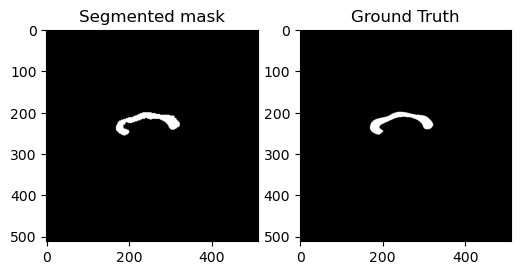

Dice: 0.8899208806329549



Brain index: 1 ================================================================================


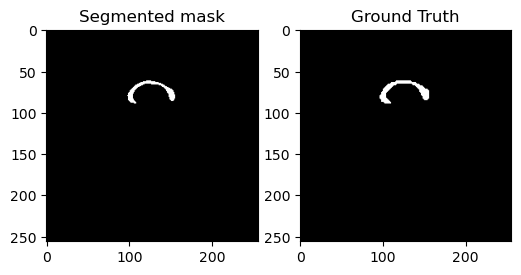

Dice: 0.8147295742232451



Brain index: 2 ================================================================================


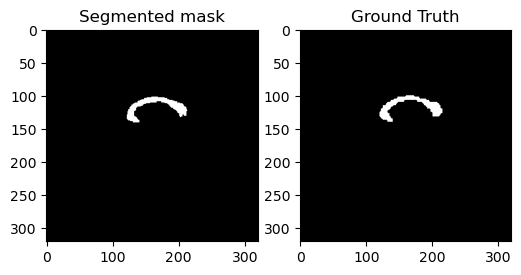

Dice: 0.816542014958205



Brain index: 3 ================================================================================


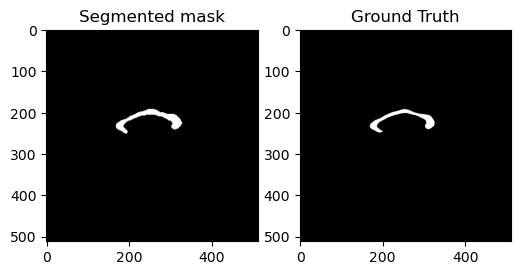

Dice: 0.8647488192357234





In [5]:
for index in range(4):
    print(
        f"Brain index: {index} ================================================================================"
    )

    # Reading the brain image and its mask
    brainMRI_path = Working_directory + "/data/brainMRI"
    listImagesbrainMRI = glob.glob(brainMRI_path + "/*-seg.png")

    filename_seg = listImagesbrainMRI[index]
    Img_seg_gt = imread(filename_seg)

    filename = filename_seg[:-8] + ".png"
    Img_brain = imread(filename)

    mask = segment_brain_pipeline(
        Img_brain=Img_brain,
        resize_shape=(256, 256),
        center_shape=(140, 100),
        equalize_adapthist_clip_limit=0.04,
        median_filter_size=4,
        initial_lower_bound=0.1,
        Target_value_thresh=0.6,
        nber_clusters=5,
        objects_min_size=150,
    )

    # visualizations
    fig, axes = plt.subplots(1, 2, figsize=(6, 5))
    ax = axes.ravel()

    ax[0].imshow(mask, cmap="gray")
    ax[0].set_title("Segmented mask")
    ax[1].imshow(Img_seg_gt, cmap="gray")
    ax[1].set_title("Ground Truth")

    mask = mask // 255
    Img_seg_gt = Img_seg_gt // 255

    plt.show()

    Dice = (
        np.sum(np.logical_and(mask, Img_seg_gt))
        * 2.0
        / (np.sum(mask) + np.sum(Img_seg_gt))
    )

    print(f"Dice: {Dice}")
    print("\n\n")

In the context of brain imagery, a comprehensive pipeline was successfully developed for all images, consistently producing segmented masks of the corpus callosum. The implementation, utilizing identical hyperparameters across cases, achieved a Dice coefficient surpassing $80%$. Upon qualitative analysis of the original brain images, it is evident that the segmented masks align well with the structures present, reinforcing the reliability of the segmentation process.